<h1><center> Data Reduction Example Using RHO Data </center></h1>

The following is a notebook explaining some basic data reduction using sample data from the Rosemary Hill Observatory (RHO) at the University of Florida. We will use similar techniques applied from the data reduction notebook from AstroPy found [Here](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html).

The basic data reduction formula is given by:

$$
    \text{star} + \text{noise} = \frac{\text{raw image} - \text{master bias} - \text{dark current}}{\text{normalized master flat}} - \text{sky}
$$

We will cover what each of these components are and how to use them to perform astronomy data reduction


# Raw Image

We collected data of a the variable star [RR Geminorum](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=RR+Geminorum&submit=SIMBAD+search) in a single filter (G). We will be reducing this data and show how does the noise change as we perform the callibration of the data.

First, let's open a single raw frame of this star:

In [1]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize
import os
import matplotlib.pyplot as plt

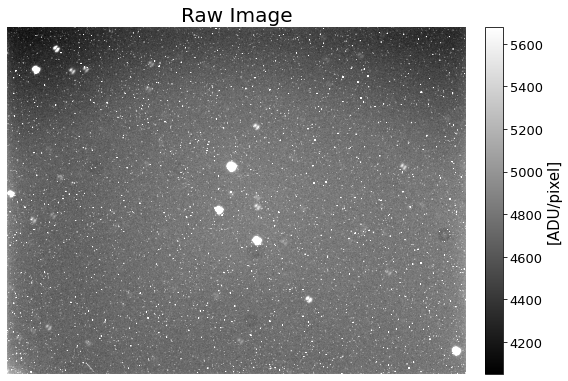

In [2]:
# Define the directory where the data is stored
data_dir = './rho_data_reduction_pipeline/data/2024-04-15/'

# From the list of files, open a raw light frame based on the header information
raw_image_file = [file for file in os.listdir(data_dir)
                 if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                 if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Light'][0]

# Get the image data from the file
raw_image_data = fits.getdata(os.path.join(data_dir, raw_image_file)).astype(float)

# Display the image
raw_image_zscaled = ImageNormalize(raw_image_data, interval=ZScaleInterval())

fig, ax = plt.subplots(1, 1, figsize=(8,8), tight_layout=True)
im = ax.imshow(raw_image_data, cmap='gray', origin='lower', norm=raw_image_zscaled)

ax.set_title('Raw Image', size=20)
ax.axis('off')

# Set up the colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label('[ADU/pixel]', size=15)
cbar.ax.tick_params(labelsize=13) 

plt.show()

# Master Bias

When collecting astronomical images through CCD, there is an offset voltage called the **Bias** caused by the readout of the instrument. This offset can be reduced by using a *Master Bias Frame* created using the individual bias frames collected during the observing night for callibration. 

In [3]:
# Create a list of the bias frame files
bias_files = [file for file in os.listdir(data_dir)
                 if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                 if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Bias']

## Basic Median Combine Using Numpy

The easiest and most basic way to create a master bias is to meadian combine the individual frames into one. We first store the image data into an array, and then perform the median-combination using `np.median(biases_data, axis=0)`

In [4]:
import numpy as np

In [15]:
# Open the bias frames data into an array
biases_data = np.array([fits.getdata(os.path.join(data_dir, file)).astype(float) for file in bias_files])

# Median-compbine the bias data to create the master bias frame
master_bias = np.median(biases_data, axis=0)

# Dark Current

The temperature of the individual pixels of a CCD is subject to change due to different factors, such as the electron motion, detector temperature, among others. This thermal contribution called the **Dark Current** can normaly be removed by cooling the CCD down. This noise source is usually reported in units of electrons/pixel/second. Thus, not only the temperature of the detector has an influence on the dark current, but also the exposure time that the image was collected with.

To calculate the dark current contribution to the raw images, we can use the following:

$$
    \text{dark current} + \text{noise} = \text{raw light exposure time} \times \frac{\text{dark frame} - \text{master bias}}{\text{dark exposure time}}
$$

In the equation above, we scaled the dark current to the exposure time of the raw light frame. Typicaly this is done when we do not have appropriate dark frames with the same exposure time as our light frames. 

Additionally, in principle every dark image comes with a bias offset when collected with a CCD. So, one can take care of this bias offset by median combining all dark frames into a *Master Dark* frame, and that will take care of the bias. 

**NOTE: This assumption is only valid when you have a dark frame of the same exposure time as the frame you want to remove the dark current from. Otherwise, you have to scale the the dark current of the closest dark frame you have.**

Assuming this simplification, then our data reduction formula becomes:

$$
    \text{star} + \text{noise} = \frac{\text{raw image} - \text{master dark}}{\text{normalized master flat}} - \text{sky}
$$

Since our saple data has matching exposure times for both the light and the dark frames, we will continue the data reduction process with this assumption and create a master dark frame.

## Master Dark Frame - Median Combine with NumPy

In [16]:
# Get the exposure time(s) of the light frames
light_exposure_time = np.unique([fits.getheader(os.path.join(data_dir,file))['EXPTIME'] 
                                 for file in os.listdir(data_dir)
                                 if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                                 if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Light'])

# If there's only one exposure time then extract the dark frames corresponding to that exposure time
if light_exposure_time.size == 1:
    dark_frames = [fits.getdata(os.path.join(data_dir, file)) for file in os.listdir(data_dir)
                   if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                   if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Dark'
                   if fits.getheader(os.path.join(data_dir, file))['EXPTIME'] == light_exposure_time[0]]
    
# Create the master dark frame by median combining the individual frames
master_dark = np.median(np.array(dark_frames), axis=0)

We can plot the master bias frame and the master dark next to each other an compare their count level

/home/fmendez/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


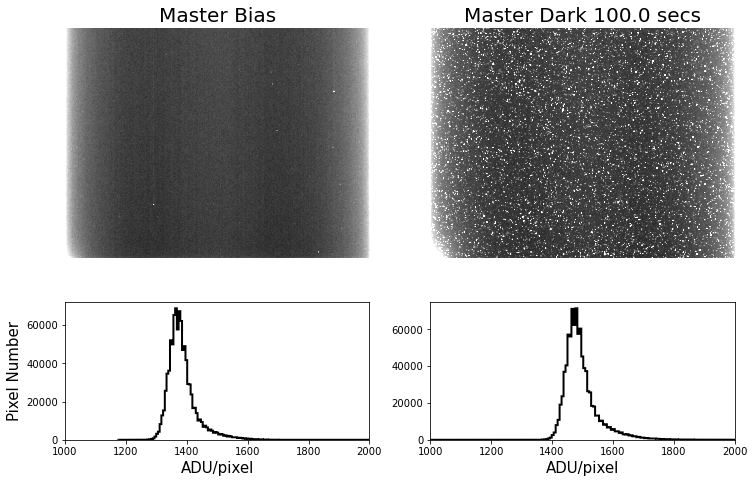

In [100]:
from matplotlib.gridspec import GridSpec

# Define the gridspec for the plot
fig = plt.figure(figsize=(12, 8), tight_layout=True)
gs = GridSpec(2, 2, height_ratios=[2, 1], hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Normalize the master bias and master dark to zscale
master_bias_zscaled = ImageNormalize(master_bias, interval=ZScaleInterval())
master_dark_zscaled = ImageNormalize(master_dark, interval=ZScaleInterval())

# Plot the images
ax1.imshow(master_bias, origin='lower', cmap='gray', norm=master_bias_zscaled)
ax2.imshow(master_dark, origin='lower', cmap='gray', norm=master_dark_zscaled)

# Plot the flattened histogram of the master frames
ax3.hist(master_bias.ravel(), bins=5000, histtype='step', color='k', lw=2)
ax4.hist(master_dark.ravel(), bins=10000, histtype='step', color='k', lw=2)

# Set the limits of the histograms x-axis
ax3.set_xlim(1000, 2000)
ax4.set_xlim(1000, 2000)

# Set up the labels of the plot
ax1.set_title('Master Bias', size=20)
ax2.set_title(f"Master Dark {light_exposure_time[0]} secs", size=20)
ax3.set_ylabel('Pixel Number', size=15)
ax3.set_xlabel('ADU/pixel', size=15)
ax4.set_xlabel('ADU/pixel', size=15)

ax1.axis('off')
ax2.axis('off')

plt.show()

From the histogram distributions it can be seen that the master bias and master dark frames have slightly different, where the mean value of the master dark is larger. This difference is coming fromt the dark current present in the dark frame, which gets larger and larger as the exposure time increases. Yet, we can still see the same distribution and gradient from the master bias in the master dark. Thus, by just subtracting the master dark from our light frames we would account for both the offset and dark current.

We will now look at the difference between a raw light frame and a de-biased, dark-subtracted light frame.

## Dark Subtraction

/home/fmendez/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


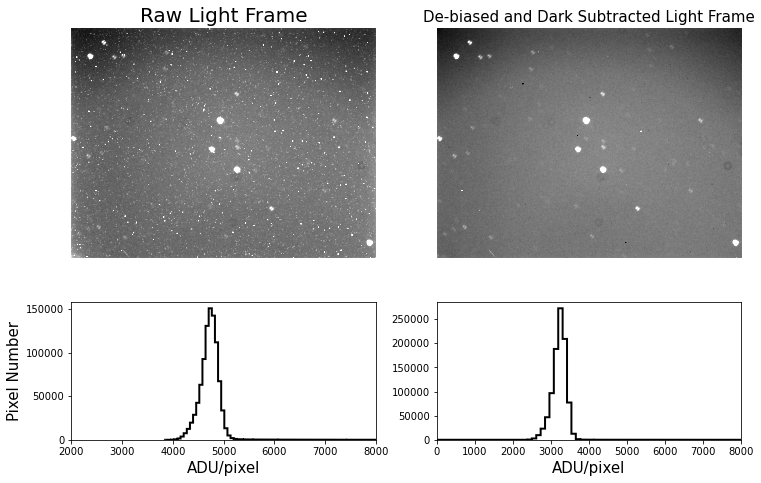

In [62]:
# Subtract the master dark from the single raw image frame
dark_subtracted_light_frame = raw_image_data - master_dark

# Plot both the raw light frame and the dark subtracted for comparison
# Define the gridspec for the plot
fig = plt.figure(figsize=(12, 8), tight_layout=True)
gs = GridSpec(2, 2, height_ratios=[2, 1], hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])

# Normalized the dark subtracted light frame to zscale
dark_subtracted_light_frame_zscaled = ImageNormalize(dark_subtracted_light_frame, interval=ZScaleInterval())

# Plot the images
ax1.imshow(raw_image_data, origin='lower', cmap='gray', norm=raw_image_zscaled)
ax2.imshow(dark_subtracted_light_frame, origin='lower', cmap='gray', norm=dark_subtracted_light_frame_zscaled)

# Plot the flattened histogram of the master frames
ax3.hist(raw_image_data.ravel(), bins=1000, histtype='step', color='k', lw=2)
ax4.hist(dark_subtracted_light_frame.ravel(), bins=1000, histtype='step', color='k', lw=2)

# Set the limits of the histograms x-axis
ax3.set_xlim(2000, 8000)
ax4.set_xlim(0, 8000)

ax1.axis('off')
ax2.axis('off')

# Set up the labels of the plot
ax1.set_title('Raw Light Frame', size=20)
ax2.set_title(f"De-biased and Dark Subtracted Light Frame", size=15)
ax3.set_ylabel('Pixel Number', size=15)
ax3.set_xlabel('ADU/pixel', size=15)
ax4.set_xlabel('ADU/pixel', size=15)

plt.show()

By looking at the images only, we can already tell that the dark-subtracted single frame already looks much better. Most of the hot pixels present in the raw data are gone. The only noise source we have to take care of now are the vignetting on the top corners, some dust grains from the telescope lens, which can be seen as dark *donuts* on the image, and finally the sky brightness.

We can take care of the first 2 by flat-fielding the image. This is the next step we will look into.

# Flat-Fielding

The response of the CCD to the light collection is never uniform. Some of the causes of this non-uniform response are:

* Different sensitivity per pixel
* Dust on the filters or the telescope
* Vignetting or dimming on the image corners

The solution is taking an uniformly iluminated image of a continuous light source called a **Flat Frame**. This frame can either be taken with the twilight sky, a dome screen, or the sky itself. In the case of RHO, we use a flat screen.

Looking at the data reduction formula, the dar-subtracted image is being divided by the Master Flat frame. Since we do not want to loose any photons coming from the star light, it is important to normalize the master flat, so that the final image is just divided by 1.

## Reducing Flat Frames

Before we can create a master flat frame, we have to reduce the individual frames first. Since these frames are images of a light sourse, they also contain the same amount of noise we have seen before (offset and dark current). Thus, we can eliminate that noise following the same formulas from above:

$$
    \text{reduced flat frame} + \text{noise} = \text{raw flat frame} - \text{master bias} - \text{dark current}
$$

However, just like dark-subtracting the raw light frame we can simplify this formula **ONLY IF** we have dark frames taken at the same exposure time as our flat frames. In that case the formula becomes

$$
    \text{reduced flat frame} + \text{noise} = \text{raw flat frame} - \text{master dark}
$$

For this example, we know that we have these dark frames, so we can used the simplified version. First, we will find the associated dark frames to the flat frames and create a master dark frame for that exposure time.

In [65]:
# Get the exposure times of the flat fields
flat_exposure_time = np.unique([fits.getheader(os.path.join(data_dir,file))['EXPTIME'] 
                                 for file in os.listdir(data_dir)
                                 if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                                 if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Flat'])

# If there's only one exposure time then extract the dark frames corresponding to that exposure time
if flat_exposure_time.size == 1:
    dark_flat_frames = [fits.getdata(os.path.join(data_dir, file)) for file in os.listdir(data_dir)
                   if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                   if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Dark'
                   if fits.getheader(os.path.join(data_dir, file))['EXPTIME'] == flat_exposure_time[0]]
    
# Create the master dark frame by median combining the individual frames
master_dark_flat = np.median(np.array(dark_flat_frames), axis=0)

Once we have the **Master Dark Flat Frame** we can then calibrate our individual flat frames by dark-subtracting them. Then, we normalize it by dividing it by its mean value.

In [70]:
# Dark-subtract the individual flat frames
calibrated_flat_frames = [fits.getdata(os.path.join(data_dir, file)).astype(float) - master_dark_flat
                         for file in os.listdir(data_dir)
                         if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                         if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Flat']

# Create the master flat frame by median combining them
master_flat = np.array(np.median(calibrated_flat_frames, axis=0))

# Normalize the master flat by dividing the entire frame by its mean value
normalized_master_flat = master_flat / master_flat.mean()

Let's a raw flat frame, the master flat, and the normalized master flat

/home/fmendez/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


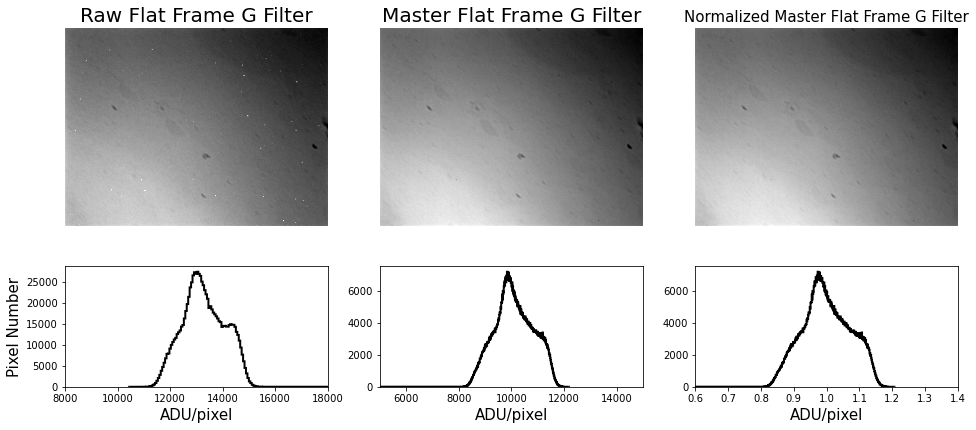

In [98]:
# Get a single raw flat frame
raw_flat_frame = [fits.getdata(os.path.join(data_dir, file)).astype(float)
                         for file in os.listdir(data_dir)
                         if fits.getheader(os.path.join(data_dir, file))['OBJECT'] == 'RRGEMINORUM'
                         if fits.getheader(os.path.join(data_dir, file))['FRAME'] == 'Flat'][0]

# Define the gridspec for the plot
fig = plt.figure(figsize=(16, 7), tight_layout=True)
gs = GridSpec(2, 3, height_ratios=[2, 1], hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])

# Normalize each frame to zscale
raw_flat_frame_zscaled = ImageNormalize(raw_flat_frame, interval=ZScaleInterval())
master_flat_zscaled = ImageNormalize(master_flat, interval=ZScaleInterval())
normalized_master_flat_zscaled = ImageNormalize(normalized_master_flat, interval=ZScaleInterval())

# Plot the respective frames
ax1.imshow(raw_flat_frame, origin='lower', cmap='gray', norm=raw_flat_frame_zscaled)
ax2.imshow(master_flat, origin='lower', cmap='gray', norm=master_flat_zscaled)
ax3.imshow(normalized_master_flat, origin='lower', cmap='gray', norm=normalized_master_flat_zscaled)

# Plot the flattened histogram of the frames
ax4.hist(raw_flat_frame.ravel(), bins=1000, histtype='step', color='k', lw=2)
ax5.hist(master_flat.ravel(), bins=1000, histtype='step', color='k', lw=2)
ax6.hist(normalized_master_flat.ravel(), bins=1000, histtype='step', color='k', lw=2)

# Set up the limits to the x-axis
ax4.set_xlim(8000,18000)
ax5.set_xlim(5000,15000)
ax6.set_xlim(0.6,1.4)

# Set up the labels of the plots
ax1.set_title('Raw Flat Frame G Filter', size=20)
ax2.set_title('Master Flat Frame G Filter', size=20)
ax3.set_title('Normalized Master Flat Frame G Filter', size=15)
ax4.set_ylabel('Pixel Number', size=15)
ax4.set_xlabel('ADU/pixel', size=15)
ax5.set_xlabel('ADU/pixel', size=15)
ax6.set_xlabel('ADU/pixel', size=15)


ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

From these plots we can see that the raw frame has the presence of some hot pixels, which after dark-subtracting the individual frames and median-combining them they disappear in the master flat frame. Then, once we normalize these frames, the mean value seen in the histogram is aroun 1.0 [ADU/pixel], yet the structure of the master frame is kept constant

Finally, we can reduce the raw light frames now that we have all the required calibration frames.

# Image Reduction

Following the simplified formula for data reduction shown earlier, we reduce a single raw light frame. Then we compare the raw light frame, dark-subtracted frame, and the flat-fielded frame all together.

/home/fmendez/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


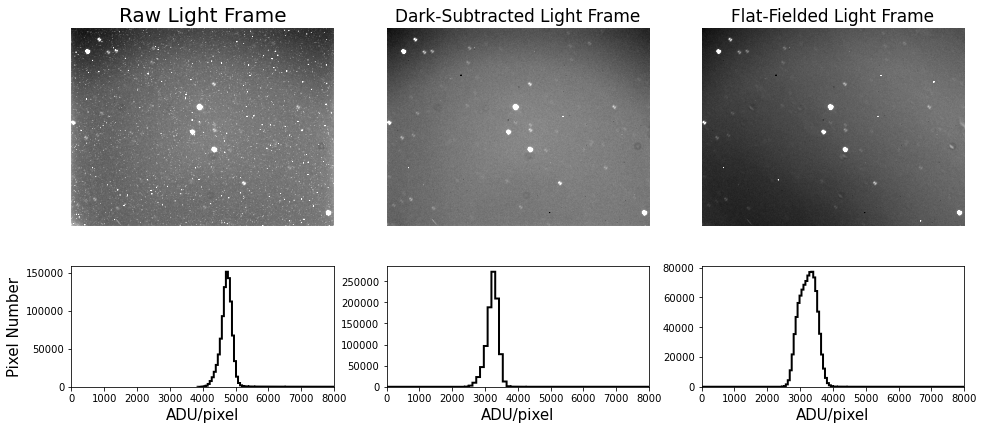

In [112]:
# Flat-field the dark-subtracted light frame
flat_fielded_dark_subtracted_light_frame = dark_subtracted_light_frame / normalized_master_flat

# Define the gridspec for the plot
fig = plt.figure(figsize=(16, 7), tight_layout=True)
gs = GridSpec(2, 3, height_ratios=[2, 1], hspace=0.1)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])

# Normalized the reduced frame to zscale
flat_fielded_dark_subtracted_light_frame_zscaled = ImageNormalize(flat_fielded_dark_subtracted_light_frame,
                                                                 interval=ZScaleInterval())

# Plot the images
ax1.imshow(raw_image_data, origin='lower', cmap='gray', norm=raw_image_zscaled)
ax2.imshow(dark_subtracted_light_frame, origin='lower', cmap='gray', norm=dark_subtracted_light_frame_zscaled)
ax3.imshow(flat_fielded_dark_subtracted_light_frame, origin='lower', cmap='gray', 
           norm=flat_fielded_dark_subtracted_light_frame_zscaled)

# Plot the flattened histogram of the frames
ax4.hist(raw_image_data.ravel(), bins=1000, histtype='step', color='k', lw=2)
ax5.hist(dark_subtracted_light_frame.ravel(), bins=1000, histtype='step', color='k', lw=2)
ax6.hist(flat_fielded_dark_subtracted_light_frame.ravel(), bins=5000, histtype='step', color='k', lw=2)

# Set up the limits to the x-axis
ax4.set_xlim(0,8000)
ax5.set_xlim(0,8000)
ax6.set_xlim(0,8000)

# Set up the labels of the plots
ax1.set_title('Raw Light Frame', size=20)
ax2.set_title('Dark-Subtracted Light Frame', size=17)
ax3.set_title('Flat-Fielded Light Frame', size=17)
ax4.set_ylabel('Pixel Number', size=15)
ax4.set_xlabel('ADU/pixel', size=15)
ax5.set_xlabel('ADU/pixel', size=15)
ax6.set_xlabel('ADU/pixel', size=15)


ax1.axis('off')
ax2.axis('off')
ax3.axis('off')


plt.show()

Overall, we can see a change in the structure of the light fram from its raw stage to the flat-fielded stage. From raw stage to dark-subtracted we can see the removal of the many hot pixels in the image and also a shift to the left on the distribution of ADU/pixels. Then, from dark-subtracted to flat-fielded we see a change in the overall brightness distribution of the image, where most of the background brightness is removed from the image. We also see this brightness distribution change in the histogram, where the mean value of the distribution stays around the same ADU/pixel, but the Gaussian shape looks much smoother relative to its dark-subtracted stage.

The remaining brightness in the flat-fielded light frame can be coming from just the sky brightness, which we will remove in the next stage.